In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import utils as u

In [3]:
EQ_CENTS = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
JI_CENTS = np.array([0, 90, 112, 182, 204, 294, 316, 386, 408, 498, 520, 590, 612, 702, 792, 814, 884, 906, 996, 1018, 1088, 1110, 1200])
sr = 16000

In [36]:
# Load processed pitch data
pitchfile = "kalyani/Kailasapathe/Kailasapathe.multitrack-vocal-main-processed.pitch"
times, f0 = np.loadtxt(pitchfile).T
length_s = times[-1]

# Track info
raga, piece, instrument, section = u.process_filename(pitchfile)
print("Raga:", raga)
print("Piece:", piece)
print("Instrument:", instrument)
print("Section:", section)

# Load the tonics
vitonic_path = raga + "/" + piece + "/" + piece + ".multitrack-violin-main.tonic"
votonic_path = raga + "/" + piece + "/" + piece + ".ctonic.txt"
tonic_violin = np.loadtxt(vitonic_path)
tonic_vocal = np.loadtxt(votonic_path)
print("Violin tonic:", tonic_violin, "Hz, Vocal tonic:", tonic_vocal, "Hz")

# Set the tonic based on the instrument
if instrument == "vocal":
    tonic = tonic_vocal
    print("Using vocal tonic")
else:
    tonic = tonic_violin
    print("Using violin tonic")

Raga: kalyani
Piece: Kailasapathe
Instrument: vocal
Section: main
Violin tonic: 176.9892578125 Hz, Vocal tonic: 176.9892578125 Hz
Using vocal tonic


In [37]:
# Cents calculation
cents = u.hz_to_cents(f0, tonic)
cents = u.wrap_to_octave(cents)

#### Histogram

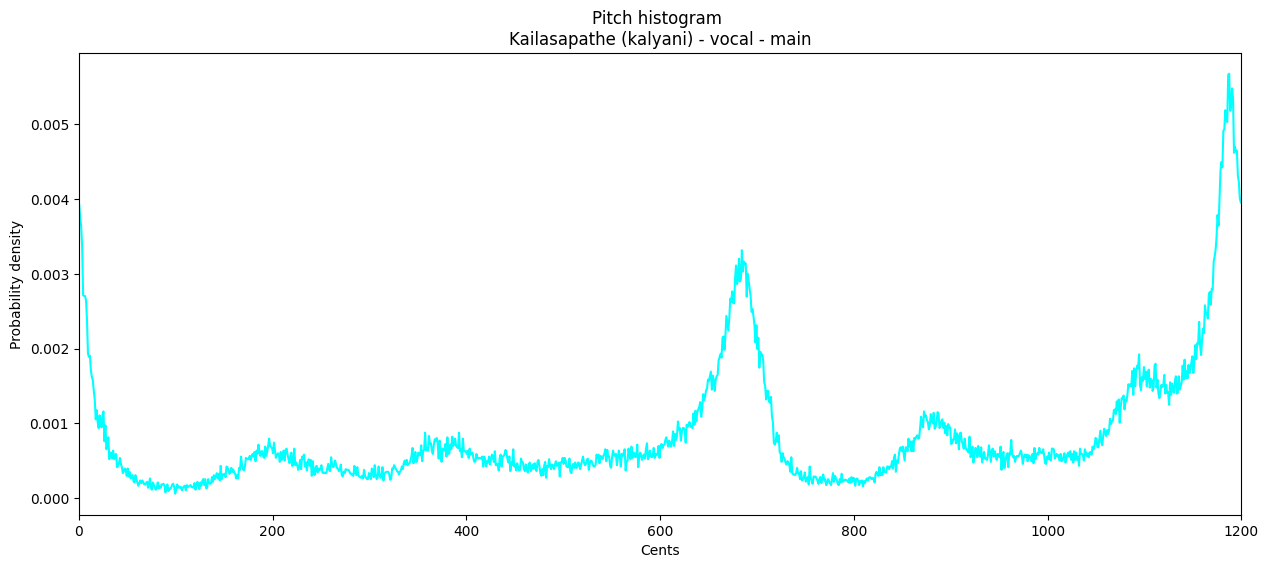

In [38]:
# Plot histogram
bins = np.linspace(0, 1200, 1201)
hist, bin_edges = np.histogram(cents, bins = bins)
hist = hist/np.sum(hist)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2    

plt.figure(figsize=(15, 6))
plt.plot(bin_centers, hist, color = "cyan")
plt.xlabel("Cents")
plt.ylabel("Probability density")
plt.xlim(0, 1200)
plt.title("Pitch histogram \n" + piece + " (" + raga + ") - " + instrument + " - " + section)
plt.show()       

# Save histogram
hist_file = pitchfile.replace("processed.pitch", "histogram.txt")
np.savetxt(hist_file, np.vstack((bin_centers, hist)).T, fmt = "%.6f")


#### KDE

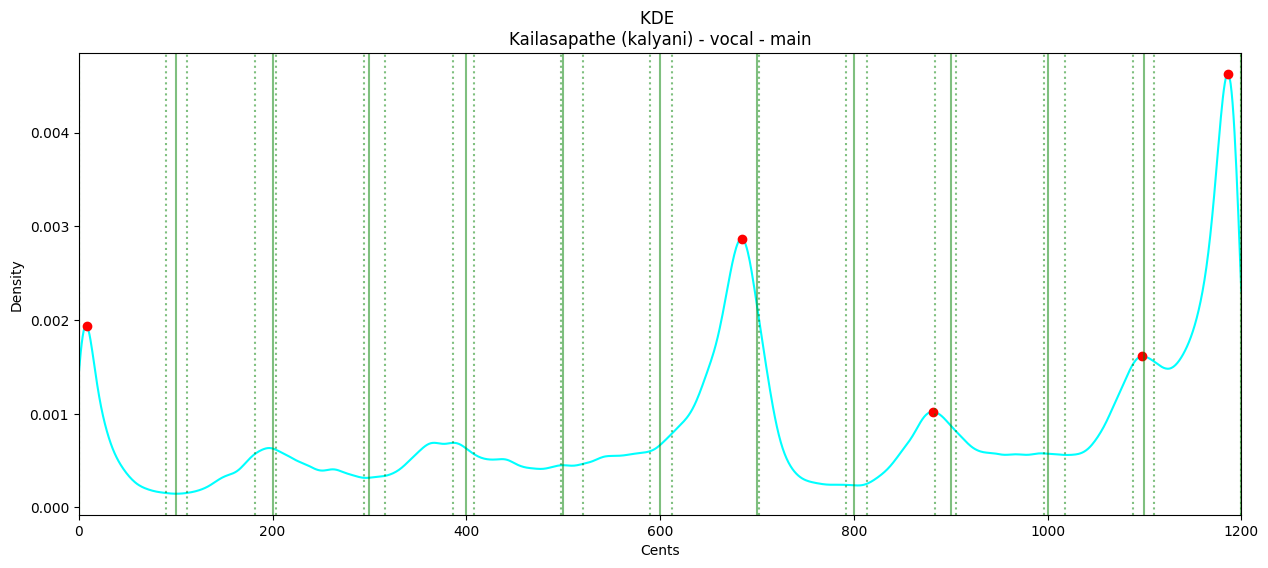

In [39]:
# KDE calculation
kde = u.gaussian_kde(cents[~np.isnan(cents)], bw_method = 0.02)
bins = np.linspace(0, 1200, 1200)
kde_vals = kde(bins)

# Find peaks in KDE
peaks,_ = u.find_peaks(kde_vals, distance = 50, height = 0.0008)

# Plot KDE and peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE \n" + piece + " (" + raga + ") - " + instrument + " - " + section)
plt.show()


#### Peak Fitting

Error fitting peak at index 1097: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.


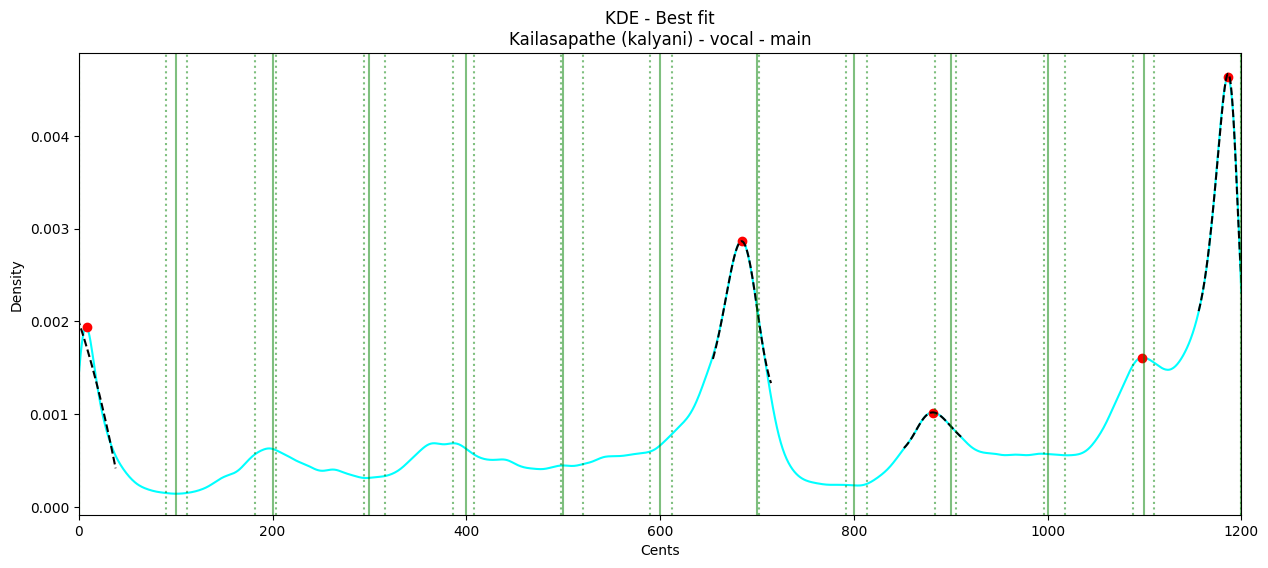

In [45]:
# Find peak parameters
peak_dict = u.fit_histogram(peaks, kde_vals, bins, extent = 25)

# Plot KDE and fitted peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for peak, params in peak_dict.items():
    start = peak - 30
    end = peak + 30
    x_vals = np.linspace(start, end, 100)
    y_vals = u.gaussian(x_vals, *params)
    plt.plot(x_vals, y_vals, linestyle = '--', color = 'k')

for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE - Best fit\n" + piece + " (" + raga + ") - " + instrument + " - " + section)

# Save figure
figfile = pitchfile.replace("processed.pitch", "kde.png")
plt.savefig(figfile)
plt.show()

# Save KDE
KDE_file = pitchfile.replace("processed.pitch", "KDE.txt")
np.savetxt(KDE_file, np.vstack((bins, kde_vals)).T, fmt = "%.6f")

In [46]:
import pandas as pd

# Store the peak parameters in a dataframe
mean_pos = [int(key) for key in peak_dict.keys()]
amplitudes = [value[0] for value in peak_dict.values()]
stds = [value[2] for value in peak_dict.values()]
offsets = [value[3] for value in peak_dict.values()]
skewness = [value[4] for value in peak_dict.values()]

# If there are negative amplitudes, remove the corresponding peaks
if any(np.array(amplitudes) < 0):
    print("Negative amplitudes detected. Removing peaks with negative amplitudes")
    mean_pos = [mean_pos[i] for i in range(len(amplitudes)) if amplitudes[i] >= 0]
    stds = [stds[i] for i in range(len(amplitudes)) if amplitudes[i] >= 0]
    offsets = [offsets[i] for i in range(len(amplitudes)) if amplitudes[i] >= 0]
    skewness = [skewness[i] for i in range(len(amplitudes)) if amplitudes[i] >= 0]
    amplitudes = [amplitudes[i] for i in range(len(amplitudes)) if amplitudes[i] >= 0]

# Normalize the amplitudes and offsets as they are in arbitrary units
amplitudes = amplitudes/np.sum(amplitudes)
offsets = offsets/np.sum(offsets)

# Display the peak parameters
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(list(zip(mean_pos, amplitudes, stds, offsets, skewness)), columns = ["Mean (cents)", "Amplitude (normalized)", "Standard Deviation (cents)", "Offset (normalized)", "Skewness"])
display(df)

# Save df to a file
csvfile = pitchfile.replace("processed.pitch", "peaks.csv")
df.to_csv(csvfile, index = False)

Negative amplitudes detected. Removing peaks with negative amplitudes


,Mean (cents),Amplitude (normalized),Standard Deviation (cents),Offset (normalized),Skewness
0,684,0.38,23.15,0.32,-1.55
1,881,0.09,29.62,0.16,2.26
2,1185,0.53,18.05,0.51,-2.99
